# CLIP (Contrastive Language-Image Pre-training))
[A. Radford, J. W. Kim, C. Hallacy, et al., "Learning Transferable Visual Models from Natural Language Supervision" arXiv, 2021.](https://arxiv.org/abs/2103.00020)

* New approch to link images and texts, enabling scalable supervised learning by using natural language

* Contrastive pre-training
  1. Extract feature representations of each modality.
```
I_f = image_encoder(image) # [N, D_i]
T_f = text_encoder(text)   # [N, D_t]
```
```
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
```

  2. Calculate the cosin similarity for each pair.
```
logits = np.dot(I_e, T_e.T) * np.exp(t)  # [N, N]
```

  3. Campute the cross-entropy using symmetric loss function.
```
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```

* Zero-shot prediction
  1. Create a list of label text: `A photo of a {class_name}`
  2. Extract feature representations from input images and the above text list<br>
     and calculate the similarity for each label text
  3. Pick the text with highest score as the answer


In [11]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Mounted at /content/drive


In [12]:
%pip install -q matplotlib torchviz torchinfo
%pip -q install "git+https://github.com/openai/CLIP.git"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
from torch import nn
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Quick Hands-on with CLIP Zero-shot Prediction

In [14]:
def visualize(image, texts, scores, figsize=(6,3), topk=5):
    top_scores, top_idx = scores.topk(topk)

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.05)

    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(image)
    ax_img.axis("off")

    ax_txt = fig.add_subplot(gs[1])
    captions = [
        f"Ground Truth:",
        texts[label],
        '\n',
        'Prediction:',
    ] + [f"{i+1}. {texts[top_idx[i]]}: {top_scores[i]:.2f}" for i in range(topk)]
    ax_txt.text(0, 1, '\n'.join(captions), ha="left", va="top")
    ax_txt.axis("off")

    plt.show()

In [15]:
!rsync -auv {DRIVE_ROOT}/datasets/food-101.tar.gz {DATA_ROOT}/

sending incremental file list
food-101.tar.gz

sent 4,997,498,228 bytes  received 35 bytes  48,756,080.61 bytes/sec
total size is 4,996,278,331  speedup is 1.00


In [19]:
# Set up the today dataset.
dataset = datasets.Food101(root=DATA_ROOT, download=True)
classes = dataset.classes

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 36.5MiB/s]


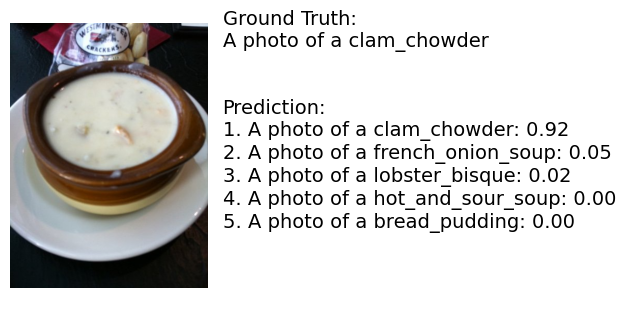

In [20]:
import clip
import random
from PIL import Image

# Pick a pair of image and text randomly.
rand_idx = random.randrange(len(dataset))
image, label = dataset[rand_idx]

# Set up a CLIP model.
device = get_device()
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

with torch.inference_mode():
    # Extract feature representations of input image.
    image_t = preprocess(image).unsqueeze(0).to(device)  # [1, C, H, W]
    image_f = model.encode_image(image_t)                # [1, D]
    image_f /= image_f.norm(dim=-1, keepdim=True)

    # Extract feature representations of input text
    texts = [f"A photo of a {class_name}" for class_name in classes]
    tokens = clip.tokenize(texts).to(device)  # [N_class, token_length]
    texts_f = model.encode_text(tokens)       # [N_class, D]
    texts_f /= texts_f.norm(dim=-1, keepdim=True)

    # Compute the cosine similarity between the encoded image and text.
    scale_factor = model.logit_scale.exp()
    logits = (image_f @ texts_f.T).squeeze(0) * scale_factor  # [N_class]
    scores = logits.softmax(dim=-1)                           # [N_class]

visualize(image, texts, scores)

## Contrastive pre-training

In [21]:
from torch import nn
import torchvision

class VisionEncoder(nn.Module):
    def __init__(self, emb_dim=512, pretrained=True):
        super().__init__()
        self.vision_encoder = torchvision.models.vit_b_32(pretrained=pretrained)
        hidden_dim = self.vision_encoder.heads[-1].in_features
        self.vision_encoder.heads = nn.Linear(hidden_dim, emb_dim, bias=False)

    def forward(self, x):
        return self.vision_encoder(x)

vision_encoder = VisionEncoder()
image_t = preprocess(image).unsqueeze(0).to('cpu')  # [1, C, H, W]
x = vision_encoder(image_t)
x.shape

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512])

In [29]:
# %pip -q install transformers
from transformers import CLIPTokenizerFast

class CLIPTokenizer:
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.tokenizer = CLIPTokenizerFast.from_pretrained(model_name)

    def __call__(self, text):
        return self.tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")['input_ids']

    @property
    def vocab_size(self) -> int:
        return self.tokenizer.vocab_size

tokenizer = CLIPTokenizer()
tokenizer('This is a photo of frog, but it looks bird from the viewpoint of taste.')

(tensor([[49406,   589,   533,   320,  1125,   539, 11438,   267,   767,   585,
           1606,  3329,   633,   518, 41604,   539,  5219,   269, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407]]),
 49408)

In [34]:
from torch import nn
import torch

class TextEncoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        context_length: int = 77,
        embed_dim: int = 512,     # 出力の共通次元（画像側と揃える）
        text_width: int = 512,    # Transformer の隠れ次元
        text_layers: int = 12,
        text_heads: int = 8,
        pad_id: int = 0,
        ff_mult: int = 4,         # FFN 係数
        dropout: float = 0.0,
        norm_first: bool = True,
    ):
        super().__init__()
        self.context_length = context_length

        # token / pos embedding
        self.token_embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=text_width,
            padding_idx=pad_id,
        )
        self.positional_embedding = nn.Parameter(
            torch.empty(context_length, text_width)
        )

        # TransformerEncoder（LND を想定して batch_first=False）
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=text_width,
            nhead=text_heads,
            dim_feedforward=ff_mult * text_width,
            dropout=dropout,
            activation="gelu",
            batch_first=False,
            norm_first=norm_first,
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=text_layers
        )

        self.layer_norm = nn.LayerNorm(text_width)

        # 最終投影（[B,D] @ [D,E] -> [B,E]）
        self.text_projection = nn.Parameter(torch.empty(text_width, embed_dim))

        self.reset_parameter(text_width)

    def reset_parameter(self, text_width):
        # --- init (CLIP 風の素朴な初期化) ---
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)
        nn.init.normal_(self.text_projection, std=text_width ** -0.5)
        # LayerNorm はデフォルトで weight=1, bias=0 なのでそのまま
        # Transformer 内の bias などはデフォルト初期化に任せます

    def forward(self, text):
        x = text
        x = self.token_embedding(x)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.layer_norm(x)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection
        return x

tokenizer = CLIPTokenizer()
text_encoder = TextEncoder(vocab_size=tokenizer.vocab_size)
tokens = tokenizer('This is a photo of frog.')
x = text_encoder(tokens)
x.shape

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([1, 512])

In [ ]:
import math
from typing import Union, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


class CLIP(nn.Module):
    """
    Minimal CLIP: ViT-B/32 image encoder + Transformer text encoder + projection heads.
    - encode_image(x): x shape [B,3,H,W], returns [B,embed_dim]
    - encode_text(text): text is LongTensor [B,L] or dict{'input_ids','attention_mask'}
    """
    def __init__(
        self,
        vocab_size: int,
        device: str = "cpu",
        embed_dim: int = 512,         # 画像・テキストを射影する共通次元
        text_width: int = 512,        # テキストTransformerの隠れ次元
        text_layers: int = 12,
        text_heads: int = 8,
        context_length: int = 77,
        pad_id: int = 0,
        vit_weights: Union[None, str] = "IMAGENET1K_V1",
    ):
        super().__init__()
        self.device_str = device
        self.context_length = context_length
        self.pad_id = pad_id

        # ---- Vision Encoder (ViT-B/32, headをIdentityに差し替え) ----
        if vit_weights is None:
            self.vision_encoder = torchvision.models.vit_b_32(weights=None)
        else:
            weights_enum = torchvision.models.ViT_B_32_Weights.__dict__.get(vit_weights, None)
            self.vision_encoder = torchvision.models.vit_b_32(weights=weights_enum)
        # 出力が分類logitsにならないように
        vision_width = _infer_vit_width(self.vision_encoder)
        self.vision_encoder.heads = nn.Identity()

        # 画像→共通空間
        self.visual_projection = nn.Linear(vision_width, embed_dim, bias=False)

        # ---- Text Encoder (token + pos + TransformerEncoder) ----
        self.token_embedding = nn.Embedding(vocab_size, text_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, text_width))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=text_width,
            nhead=text_heads,
            dim_feedforward=text_width * 4,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=text_layers)
        self.ln_final = nn.LayerNorm(text_width)

        # テキスト→共通空間
        self.text_projection = nn.Linear(text_width, embed_dim, bias=False)

        # ---- Temperature (logit_scale) ----
        self.logit_scale = nn.Parameter(torch.ones([]) * math.log(1 / 0.07))

        # 初期化
        self.reset_parameter()

        # 配置
        self.to(device)

    def reset_parameter(self):
        # できるだけ安定な初期化（CLIP風）
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)
        _init_transformer_(self.transformer)
        nn.init.normal_(self.text_projection.weight, std=text_proj_std(self.text_projection))
        nn.init.normal_(self.visual_projection.weight, std=0.02)
        with torch.no_grad():
            self.logit_scale.clamp_(min=math.log(1/100.0), max=math.log(100.0))  # 度が過ぎないように

    # -------- Encoders --------
    @torch.no_grad()
    def encode_image(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,3,H,W], 画像前処理は呼び出し側で実施（CLIP既定mean/stdなど）
        feats = self.vision_encoder(x)          # [B, vision_width] (class token)
        feats = self.visual_projection(feats)    # [B, embed_dim]
        return feats

    @torch.no_grad()
    def encode_text(self, text: Union[torch.LongTensor, Dict[str, torch.Tensor]]) -> torch.Tensor:
        # text: LongTensor[B,L] もしくは {'input_ids':..., 'attention_mask':...}
        if isinstance(text, dict):
            input_ids = text["input_ids"]
            attn_mask = text.get("attention_mask", None)
        else:
            input_ids = text
            attn_mask = None

        B, L = input_ids.size(0), input_ids.size(1)
        assert L <= self.context_length, f"Sequence length {L} > context_length {self.context_length}"

        x = self.token_embedding(input_ids)  # [B,L,text_width]
        pos = self.positional_embedding[:L].unsqueeze(0)  # [1,L,text_width]
        x = x + pos

        # key_padding_mask: True=無効位置
        key_padding_mask = None
        if attn_mask is not None:
            key_padding_mask = (attn_mask == 0)  # [B,L] bool

        x = self.transformer(x, src_key_padding_mask=key_padding_mask)  # [B,L,text_width]
        x = self.ln_final(x)

        # 末尾（padでない最後のトークン）を代表特徴に
        if attn_mask is not None:
            lengths = attn_mask.long().sum(dim=1).clamp(min=1) - 1  # [B]
        else:
            lengths = torch.full((B,), L - 1, device=x.device, dtype=torch.long)
        rep = x[torch.arange(B, device=x.device), lengths]          # [B,text_width]

        feats = self.text_projection(rep)                           # [B,embed_dim]
        return feats

    # -------- CLIP loss forward --------
    def forward(self, image: torch.Tensor, text: Union[torch.LongTensor, Dict[str, torch.Tensor]]):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = F.normalize(image_features, dim=1)
        text_features = F.normalize(text_features, dim=1)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp().clamp(max=100.0)
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


# ----------------- helpers -----------------

def _infer_vit_width(vit: torchvision.models.VisionTransformer) -> int:
    # heads からin_featuresを推定（実装差分に強め）
    width = None
    try:
        # torchvision>=0.13: vit.heads は nn.Sequential
        for m in vit.heads.modules():
            if isinstance(m, nn.Linear):
                width = m.in_features
                break
    except Exception:
        pass
    if width is None and hasattr(vit, "hidden_dim"):
        width = vit.hidden_dim
    if width is None:
        # フォールバック（ViT-B/32は768）
        width = 768
    return width


def _init_transformer_(encoder: nn.TransformerEncoder):
    for m in encoder.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)


def text_proj_std(layer: nn.Linear) -> float:
    # layer.d_inに応じた適度なスケール（簡易）
    fan_in = layer.weight.size(1)
    return 1.0 / math.sqrt(fan_in)


In [ ]:
import math
from typing import Union, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


class CLIP(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        device: str = "cpu",
        embed_dim: int = 512,
        # vision
        pretrained: bool = True,            # ← ユーザー指定どおり
        # text
        context_length: int = 77,
        transformer_width: int = 512,
        transformer_heads: int = 8,
        transformer_layers: int = 12,
        pad_id: int = 0,
    ):
        super().__init__()
        self.context_length = context_length
        self.pad_id = pad_id

        # ---- Vision (ViT-B/32) ----
        self.vision_encoder = torchvision.models.vit_b_32(pretrained=pretrained)
        self.vision_encoder.heads = nn.Identity()
        vision_width = _infer_vit_width(self.vision_encoder)
        # 本家は visual が embed_dim を直接返す設計なので、ここで射影
        self.visual_projection = nn.Linear(vision_width, embed_dim, bias=False)
        # 互換名（本家の encode_image と同じ書き方に）
        self.visual = self.vision_encoder

        # ---- Text ----
        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = nn.LayerNorm(transformer_width)

        # Transformer (因果マスクを適用)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_width,
            nhead=transformer_heads,
            dim_feedforward=transformer_width * 4,
            activation="gelu",
            batch_first=False,   # 本家と同様 LND で計算
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # 本家同様：線形層ではなく行列パラメータで射影
        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))

        # 温度パラメータ（logit_scale）
        self.logit_scale = nn.Parameter(torch.ones([]) * math.log(1 / 0.07))

        # 初期化
        self.initialize_parameters()

        # 配置
        self.to(device)

    # --- init (本家に準拠した範囲で) ---
    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)
        # Transformer 近似初期化
        proj_std = (self.transformer.layers[0].linear2.in_features ** -0.5) * ((2 * len(self.transformer.layers)) ** -0.5)
        attn_std = self.transformer.layers[0].self_attn.embed_dim ** -0.5
        fc_std = (2 * self.transformer.layers[0].self_attn.embed_dim) ** -0.5
        for block in self.transformer.layers:
            qkv = block.self_attn.in_proj_weight
            if qkv is not None:
                nn.init.normal_(qkv, std=attn_std)
            nn.init.normal_(block.self_attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.linear1.weight, std=fc_std)
            nn.init.normal_(block.linear2.weight, std=proj_std)
            if block.self_attn.in_proj_bias is not None:
                nn.init.zeros_(block.self_attn.in_proj_bias)
            if block.self_attn.out_proj.bias is not None:
                nn.init.zeros_(block.self_attn.out_proj.bias)
            if block.linear1.bias is not None:
                nn.init.zeros_(block.linear1.bias)
            if block.linear2.bias is not None:
                nn.init.zeros_(block.linear2.bias)

        nn.init.normal_(self.text_projection, std=(self.transformer.layers[0].self_attn.embed_dim ** -0.5))
        nn.init.normal_(self.visual_projection.weight, std=0.02)

    # 本家互換：因果（上三角）マスク
    def build_attention_mask(self, device=None, dtype=None):
        mask = torch.empty(self.context_length, self.context_length, device=device, dtype=torch.float32)
        mask.fill_(float("-inf"))
        mask.triu_(1)
        return mask.to(dtype or torch.float32)

    @property
    def dtype(self):
        return next(self.visual.parameters()).dtype

    # -------- Encoders --------
    def encode_image(self, image: torch.Tensor) -> torch.Tensor:
        x = self.visual(image.type(self.dtype))     # [B, hidden]
        x = self.visual_projection(x)               # [B, embed_dim]
        return x

    def encode_text(self, text: Union[torch.LongTensor, Dict[str, torch.Tensor]]) -> torch.Tensor:
        # text: LongTensor[B,L]（EOTが最大ID） もしくは {'input_ids','attention_mask'}
        if isinstance(text, dict):
            input_ids = text["input_ids"]
        else:
            input_ids = text
        B, L = input_ids.shape
        assert L <= self.context_length, f"seq len {L} > context_length {self.context_length}"

        x = self.token_embedding(input_ids).type(self.dtype)              # [B,L,C]
        x = x + self.positional_embedding[:L].type(self.dtype)            # [B,L,C]
        x = x.permute(1, 0, 2)                                           # NLD -> LND

        attn_mask = self.build_attention_mask(device=x.device)[:L, :L]    # [L,L]
        x = self.transformer(x, mask=attn_mask)                           # [L,B,C]
        x = x.permute(1, 0, 2)                                            # [B,L,C]
        x = self.ln_final(x).type(self.dtype)

        # EOT（最大トークンID位置）の特徴を取り出し、行列で射影
        eot_indices = input_ids.argmax(dim=-1)                             # [B]
        x = x[torch.arange(B, device=x.device), eot_indices]               # [B,C]
        x = x @ self.text_projection                                      # [B,embed_dim]
        return x

    # -------- CLIP contrastive forward --------
    def forward(self, image: torch.Tensor, text: Union[torch.LongTensor, Dict[str, torch.Tensor]]):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        image_features = F.normalize(image_features, dim=1)
        text_features = F.normalize(text_features, dim=1)

        logit_scale = self.logit_scale.exp().clamp(max=100.0)
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()
        return logits_per_image, logits_per_text


# ---- helper ----
def _infer_vit_width(vit: torchvision.models.VisionTransformer) -> int:
    # vit.heads 内から in_features を推定（フォールバックは768）
    for m in vit.heads.modules():
        if isinstance(m, nn.Linear):
            return m.in_features
    return getattr(vit, "hidden_dim", 768)


In [ ]:
import math
from typing import Union, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


# ---- helper ----
def _infer_hidden_dim(vit: torchvision.models.VisionTransformer, fallback: int = 768) -> int:
    # vit.heads 内の Linear から in_features を取得（無ければフォールバック）
    for m in vit.heads.modules():
        if isinstance(m, nn.Linear):
            return m.in_features
    return getattr(vit, "hidden_dim", fallback)


class CLIP(nn.Module):
    """
    CLIP (torchvision ViT-B/32 を使用)
      - visual: vit_b_32 の heads を Linear(hidden→embed_dim) に付け替え
      - text: causal Transformer + EOT 集約 + text_projection
    """
    def __init__(
        self,
        vocab_size: int,
        device: str = "cpu",
        embed_dim: int = 512,
        # vision
        pretrained: bool = True,         # 要望どおり pretrained=True を使用
        # text
        context_length: int = 77,
        transformer_width: int = 512,
        transformer_heads: int = 8,
        transformer_layers: int = 12,
        pad_id: int = 0,
    ):
        super().__init__()
        self.context_length = context_length
        self.pad_id = pad_id

        # ---- Vision (ViT-B/32) ----
        vit = torchvision.models.vit_b_32(pretrained=pretrained)
        hidden = _infer_hidden_dim(vit, fallback=768)
        vit.heads = nn.Linear(hidden, embed_dim, bias=False)  # ← ここで embed_dim へ投影
        nn.init.normal_(vit.heads.weight, std=0.02)
        self.visual = vit                                      # 本家と同じ呼び出し名

        # ---- Text ----
        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = nn.LayerNorm(transformer_width)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_width,
            nhead=transformer_heads,
            dim_feedforward=transformer_width * 4,
            activation="gelu",
            batch_first=False,   # LND で計算（本家準拠）
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # 本家同様：行列パラメータで射影
        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))

        # 温度パラメータ
        self.logit_scale = nn.Parameter(torch.ones([]) * math.log(1 / 0.07))

        # 初期化
        self.initialize_parameters()

        # 配置
        self.to(device)

    # --- init（本家に近い方針で簡潔化） ---
    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        # Transformer 近似初期化
        layers = list(self.transformer.layers)
        if len(layers) > 0:
            d_model = layers[0].self_attn.embed_dim
            proj_std = (d_model ** -0.5) * ((2 * len(layers)) ** -0.5)
            attn_std = d_model ** -0.5
            fc_std = (2 * d_model) ** -0.5
            for blk in layers:
                if blk.self_attn.in_proj_weight is not None:
                    nn.init.normal_(blk.self_attn.in_proj_weight, std=attn_std)
                nn.init.normal_(blk.self_attn.out_proj.weight, std=proj_std)
                nn.init.normal_(blk.linear1.weight, std=fc_std)
                nn.init.normal_(blk.linear2.weight, std=proj_std)
                if blk.self_attn.in_proj_bias is not None:
                    nn.init.zeros_(blk.self_attn.in_proj_bias)
                if blk.self_attn.out_proj.bias is not None:
                    nn.init.zeros_(blk.self_attn.out_proj.bias)
                if blk.linear1.bias is not None:
                    nn.init.zeros_(blk.linear1.bias)
                if blk.linear2.bias is not None:
                    nn.init.zeros_(blk.linear2.bias)

            nn.init.normal_(self.text_projection, std=d_model ** -0.5)

        # logit_scale を極端に振れないように（任意）
        with torch.no_grad():
            self.logit_scale.clamp_(min=math.log(1/100.0), max=math.log(100.0))

    # 本家互換：上三角（因果）マスク
    def build_attention_mask(self, L: int, device=None):
        mask = torch.empty(L, L, device=device, dtype=torch.float32)
        mask.fill_(float("-inf"))
        mask.triu_(1)
        return mask

    @property
    def dtype(self):
        return next(self.visual.parameters()).dtype

    # -------- Encoders --------
    def encode_image(self, image: torch.Tensor) -> torch.Tensor:
        # visual は heads=Linear(hidden→embed_dim) に置換済みなので、embed_dim を返す
        return self.visual(image.type(self.dtype))

    def encode_text(self, text: Union[torch.LongTensor, Dict[str, torch.Tensor]]) -> torch.Tensor:
        # text: LongTensor[B,L] もしくは {'input_ids','attention_mask'}
        if isinstance(text, dict):
            input_ids = text["input_ids"]
            attn_mask = text.get("attention_mask", None)
        else:
            input_ids = text
            attn_mask = None

        B, L = input_ids.shape
        assert L <= self.context_length, f"seq len {L} > context_length {self.context_length}"

        x = self.token_embedding(input_ids).type(self.dtype)          # [B,L,C]
        x = x + self.positional_embedding[:L].type(self.dtype)        # [B,L,C]
        x = x.permute(1, 0, 2)                                        # NLD→LND

        causal = self.build_attention_mask(L, device=x.device)        # [L,L]
        x = self.transformer(x, mask=causal)                          # [L,B,C]
        x = x.permute(1, 0, 2)                                        # [B,L,C]
        x = self.ln_final(x).type(self.dtype)

        # 代表トークン:
        # - 本家：EOT（最大ID）を使う
        # - attention_mask があれば「最後の非PAD」を使う方が安全
        if attn_mask is not None:
            lengths = attn_mask.long().sum(dim=1).clamp(min=1) - 1     # [B]
            rep = x[torch.arange(B, device=x.device), lengths]         # [B,C]
        else:
            eot_idx = input_ids.argmax(dim=-1)                         # [B]
            rep = x[torch.arange(B, device=x.device), eot_idx]         # [B,C]

        feats = rep @ self.text_projection                              # [B,embed_dim]
        return feats

    # -------- CLIP contrastive forward --------
    def forward(self, image: torch.Tensor, text: Union[torch.LongTensor, Dict[str, torch.Tensor]]):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        image_features = F.normalize(image_features, dim=1)
        text_features = F.normalize(text_features, dim=1)

        logit_scale = self.logit_scale.exp().clamp(max=100.0)
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()
        return logits_per_image, logits_per_text


In [ ]:
# train_flickr30k_simple.py
import os, math, random, time
from dataclasses import dataclass
from typing import Any, List
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.datasets import Flickr30k
from torchvision.transforms.functional import InterpolationMode
# 既存のCLIPモデルを使う（あなたの実装をインポート）
# from model import CLIP
from transformers import AutoTokenizer

@dataclass
class CFG:
    root: str = "./flickr30k"                 # 画像ディレクトリ
    ann_file: str = "./annotations/dataset_flickr30k.json"  # アノテーションJSON
    out_dir: str = "./outputs"
    image_size: int = 224
    context_length: int = 77
    tokenizer_name: str = "bert-base-uncased"
    batch_size: int = 128
    epochs: int = 5
    lr: float = 5e-4
    weight_decay: float = 0.2
    betas = (0.9, 0.98)
    num_workers: int = 8
    val_ratio: float = 0.03
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
cfg = CFG()

def set_seed(seed:int):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def build_transforms(train: bool):
    mean = (0.48145466, 0.4578275, 0.40821073)
    std  = (0.26862954, 0.26130258, 0.27577711)
    if train:
        return T.Compose([
            T.Resize(cfg.image_size, interpolation=InterpolationMode.BICUBIC),
            T.RandomResizedCrop(cfg.image_size, scale=(0.9, 1.0), interpolation=InterpolationMode.BICUBIC),
            T.RandomHorizontalFlip(),
            T.ToTensor(), T.Normalize(mean, std),
        ])
    else:
        return T.Compose([
            T.Resize(cfg.image_size, interpolation=InterpolationMode.BICUBIC),
            T.CenterCrop(cfg.image_size),
            T.ToTensor(), T.Normalize(mean, std),
        ])

# Flickr30k(root, ann_file, transform=...) をそのまま使いたいので、
# 分割用に indices を与える軽いラッパーを用意（transformはここで適用）
class SubsetWithTransform(Dataset):
    def __init__(self, base: Flickr30k, indices: List[int], transform=None):
        self.base = base
        self.indices = indices
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        img, target = self.base[self.indices[i]]  # baseのtransformはNoneで作る
        if self.transform: img = self.transform(img)
        return img, target

def pick_text(target: Any) -> str:
    # list[str] or dict{'captions': [...]} or str の想定
    if isinstance(target, (list, tuple)) and target and isinstance(target[0], str):
        return random.choice(target)
    if isinstance(target, dict) and "captions" in target and isinstance(target["captions"], list):
        return random.choice(target["captions"])
    if isinstance(target, str):
        return target
    raise ValueError(f"Unsupported target format: {type(target)}")

def collate_fn(batch, tokenizer):
    images, texts = [], []
    for img, tgt in batch:
        images.append(img)
        texts.append(pick_text(tgt))
    images = torch.stack(images, 0)
    tok = tokenizer(texts, padding="max_length", truncation=True,
                    max_length=cfg.context_length, return_tensors="pt")
    return images, tok

def clip_loss(logits_per_image, logits_per_text):
    b = logits_per_image.size(0)
    labels = torch.arange(b, device=logits_per_image.device)
    return (nn.functional.cross_entropy(logits_per_image, labels) +
            nn.functional.cross_entropy(logits_per_text, labels)) / 2

def main():
    os.makedirs(cfg.out_dir, exist_ok=True)
    set_seed(cfg.seed)

    # Dataset（transform=None で作成し、後段Subsetでtransform適用）
    base = Flickr30k(root=cfg.root, ann_file=cfg.ann_file, transform=None)
    n = len(base)
    idx = torch.randperm(n, generator=torch.Generator().manual_seed(cfg.seed)).tolist()
    val_n = max(1, int(n * cfg.val_ratio))
    val_idx, train_idx = idx[:val_n], idx[val_n:]

    train_set = SubsetWithTransform(base, train_idx, build_transforms(train=True))
    val_set   = SubsetWithTransform(base, val_idx,   build_transforms(train=False))

    tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token or tokenizer.cls_token

    train_loader = DataLoader(
        train_set, batch_size=cfg.batch_size, shuffle=True,
        num_workers=cfg.num_workers, pin_memory=True,
        collate_fn=lambda b: collate_fn(b, tokenizer)
    )
    val_loader = DataLoader(
        val_set, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True,
        collate_fn=lambda b: collate_fn(b, tokenizer)
    )

    # モデル（あなたのCLIPを利用）
    model = CLIP(
        vocab_size=tokenizer.vocab_size,
        device=cfg.device,
        pretrained=True,
        context_length=cfg.context_length,
    ).to(cfg.device)

    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, betas=cfg.betas, weight_decay=cfg.weight_decay)

    # ---- Train（超シンプル）----
    step = 0
    for epoch in range(1, cfg.epochs + 1):
        model.train()
        t0 = time.time(); running = 0.0
        for it, (images, tok) in enumerate(train_loader, 1):
            images = images.to(cfg.device, non_blocking=True)
            for k in tok: tok[k] = tok[k].to(cfg.device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            logits_i, logits_t = model(images, tok)
            loss = clip_loss(logits_i, logits_t)
            loss.backward()
            opt.step()

            running += loss.item(); step += 1
            if it % 50 == 0:
                print(f"[Ep {epoch}] it {it}/{len(train_loader)} loss {loss.item():.4f}")

        print(f"Epoch {epoch} | avg loss {running/len(train_loader):.4f} | {time.time()-t0:.1f}s")

        # 極簡易のval（損失のみ）
        model.eval()
        with torch.inference_mode():
            val_loss = 0.0
            for images, tok in val_loader:
                images = images.to(cfg.device, non_blocking=True)
                for k in tok: tok[k] = tok[k].to(cfg.device, non_blocking=True)
                li, lt = model(images, tok)
                val_loss += clip_loss(li, lt).item()
        val_loss /= max(1, len(val_loader))
        print(f"Val loss: {val_loss:.4f}")

        # 保存
        path = os.path.join(cfg.out_dir, f"clip_flickr30k_ep{epoch}.pt")
        torch.save({"model": model.state_dict(), "cfg": vars(cfg)}, path)
        print(f"Saved: {path}")

if __name__ == "__main__":
    main()
